#Text generator

In [36]:
import tensorflow.keras as keras
import tensorflow as tf
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [2]:
import numpy as np

path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path, 'r',-1, 'utf-8').read().lower()
print('corpus length:', len(text))

614400/600901 [==============================] - 0s 0us/step
corpus length: 600893


In [3]:
# Length of extracted character sequences
maxlen = 60
# We sample a new sequence every `step` characters
step = 3
# This holds our extracted sequences
sentences = []
# This holds the targets (the follow-up characters)
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))
# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)
# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 200278
Unique characters: 57
Vectorization...


In [4]:
from keras import layers
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

In [5]:
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [6]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [10]:
import random
import sys
for epoch in range(1, 60):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    model.fit(x, y,
              batch_size=128,
              epochs=1)
    # Select a text seed at random
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('--- Generating with seed: "' + generated_text + '"')
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)
        # We generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]
            generated_text += next_char
            generated_text = generated_text[1:]
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
1565/1565 [==============================] - 10s 7ms/step - loss: 1.5186
--- Generating with seed: "e that are condemned
by the method of comparison--will be al"
------ temperature: 0.2
e that are condemned
by the method of comparison--will be all the superfice of the freedom and interpustination of the will and the superiority of the freedom and always and the be all the consideration of the moral problem and conscience of the freedom and are all the desires and such a more the superiority and impostiny and all the decesting and also be are such a problem and conscience of the freedom is all the discourse of the consideration of the supe
------ temperature: 0.5
reedom is all the discourse of the consideration of the superiority is an interpleative of the fluttles. in the freedfution a
pastician all superiority in the bear to the way child always to german freedamistive in the believes with the religions the predecivition of the humanitation of these bestiny of the distingule o

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


e the interesting the strength to the strong of subjured the believed to
the faith, in a man to refreshous and allucan the tain the profoundly by history in the constume and contempt of the heart by the blensing a allected the great desire to the eventures to religion and the europe is the present it is all nothing of the things which a religion of the art of the serves all the bod
------ temperature: 1.0
things which a religion of the art of the serves all the bodier one aptray a ridere shoole dilly interesting faith," error.


1itewer of afford, between instrument there
samond--and a bod quite act wyres and perfuationd
will must been ginduse its detime, of their hun-bul nowly belief has been knowledge that seems to the world as cause everything--the pare sup-of compleces of the betrayes and error
itself up, and books, that
perhaps limitage, even "the bad 
------ temperature: 1.2

itself up, and books, that
perhaps limitage, even "the bad fetidly, that, as its will asceticy, and macki

#Style transfer

In [46]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

target_image_path = 'dog.jpeg'
style_reference_image_path = 'cartoon.jpeg'

width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [47]:
import numpy as np
from tensorflow.keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [48]:
from tensorflow.keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('model loading complete.')

model loading complete.


In [49]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [50]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [51]:
tf.compat.v1.disable_eager_execution()
grads = K.gradients(loss, combination_image)[0]

fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [55]:
from scipy.optimize import fmin_l_bfgs_b
import time
from keras_preprocessing import image

result_prefix = 'style_transfer_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('iteration:', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    end_time = time.time()
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    image.save_img(fname, img)
    end_time = time.time()
    print('current loss:', min_val)
    print(end_time - start_time)

iteration: 0
current loss: 48366326000.0
4.1514129638671875
iteration: 1
current loss: 17187105000.0
4.118008613586426
iteration: 2
current loss: 9757024000.0
4.112694978713989
iteration: 3
current loss: 7140727300.0
4.189357042312622
iteration: 4
current loss: 5922534000.0
4.1798155307769775
iteration: 5
current loss: 5210466000.0
4.2278454303741455
iteration: 6
current loss: 4737272000.0
4.249522686004639
iteration: 7
current loss: 4381393000.0
4.233470678329468
iteration: 8
current loss: 4102541800.0
4.2299485206604
iteration: 9
current loss: 3871662800.0
4.184661865234375
iteration: 10
current loss: 3662525200.0
4.263274431228638
iteration: 11
current loss: 3480413400.0
4.261659145355225
iteration: 12
current loss: 3332640300.0
4.238351345062256
iteration: 13
current loss: 3202714400.0
4.25514030456543
iteration: 14
current loss: 3082028800.0
4.257052659988403
iteration: 15
current loss: 2971905000.0
4.2471373081207275
iteration: 16
current loss: 2872212500.0
4.258079528808594
iter

original image
style image
style-transfered image


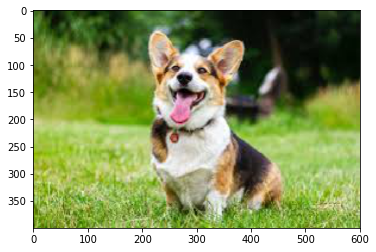

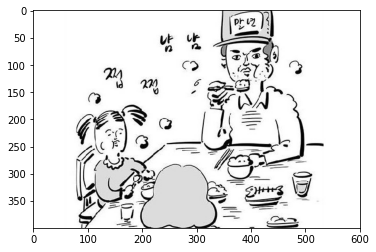

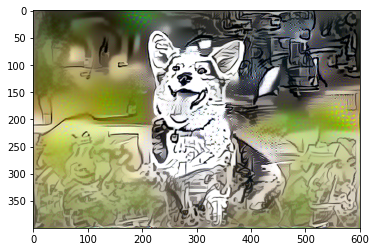

In [56]:
from matplotlib import pyplot as plt
print("original image")
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

print("style image")
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

print("style-transfered image")
plt.imshow(img)
plt.show()